In [63]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import math
from scipy.stats import iqr
from numpy import linalg
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import pickle

In [64]:
## Features

def mean(x):
    """Calculates mean"""
    mean_x = np.mean(x)
    return mean_x

def std_dev(x):
    """Calculates standard deviation"""
    std_x = np.std(x)
    return std_x
    
def mad(x):
    """Calculates median absolute deviation"""
    mad_x = np.median(np.abs(x - np.median(x)))
    return mad_x

def minimum(x):
    """Calculates minimum"""
    return min(x)

def maximum(x):
    """Calculates maximum"""
    return max(x)

def energy_measure(x):
    """Calculates energy measures"""
    em_x = np.mean(np.square(x))
    return em_x

def inter_quartile_range(x):
    """Calculates inter-quartile range"""
    iqr_x = np.subtract(*np.percentile(x, [75, 25]))
    return iqr_x

def sma(x,y,z):
    """Calculates signal magnitude area"""   
    abs_x = np.absolute(x)
    abs_y = np.absolute(y)
    abs_z = np.absolute(z)
    return np.mean(abs_x+abs_y+abs_z)

def skewness(x):
    """Calculates skewness"""
    skew_x=stats.skew(x)
    return skew_x

def kurt(x):
    """Calculates kurtosis"""
    kurt_x = stats.kurtosis(x,fisher=False)
    return kurt_x
    
def max_index(x):
    """Calculates index of maximum"""
    idx_x = np.argmax(x)
    return idx_x

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [65]:
acc_cols = ['mean_acc_x', 'mean_acc_y', 'mean_acc_z', 'std_acc_z', 'mad_acc_x', 'min_acc_x', 'min_acc_y',
            'max_acc_x', 'max_acc_y', 'max_acc_z', 'em_acc_x', 'em_acc_y', 'em_acc_z', 'sma_acc']

def process_acc(input_df, columns, output_df):
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 10000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 5000
            max_window -= 5000
            i -= int(count/2)
        x = [input_df[1][i]]
        y = [input_df[2][i]]
        z = [input_df[3][i]]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[1][i])
                y.append(input_df[2][i])
                z.append(input_df[3][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        
        mean_acc_x = mean(x)
        mean_acc_y = mean(y)
        mean_acc_z = mean(z)
        std_acc_z = std_dev(z)
        mad_acc_x = mad(x)
        min_acc_x = minimum(x)
        min_acc_y = minimum(y)
        max_acc_x = maximum(x)
        max_acc_y = maximum(y)
        max_acc_z = maximum(z)
        em_acc_x = energy_measure(x)
        em_acc_y = energy_measure(y)
        em_acc_z = energy_measure(z)
        sma_acc = sma(x, y, z)
        
        acc_data = [mean_acc_x, mean_acc_y, mean_acc_z, std_acc_z, mad_acc_x, min_acc_x, min_acc_y, max_acc_x,
                    max_acc_y, max_acc_z, em_acc_x, em_acc_y, em_acc_z, sma_acc]
        #print(acc_data)
        output_df = output_df.append(pd.Series(acc_data, index=columns), ignore_index=True)

    return output_df

In [66]:
macc_cols = ['mean_macc', 'std_macc', 'mad_macc', 'max_macc', 'em_macc', 'iqr_macc', 'sma_macc', 'label']

def process_mag_acc(input_df, columns, output_df):
    mag = np.linalg.norm(input_df.iloc[:,1:4], axis = 1)
    input_df[6] = mag.tolist()
    
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 10000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 5000
            max_window -= 5000
            i -= int(count/2)
        x = [input_df[6][i]]
        l = input_df[5][i]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[6][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        
        mean_macc = mean(x)
        std_macc = std_dev(x)
        mad_macc = mad(x)
        max_macc = maximum(x)
        em_macc = energy_measure(x)
        iqr_macc = inter_quartile_range(x)
        sma_macc = np.mean(np.absolute(x))  
        
        macc_data = [mean_macc, std_macc, mad_macc, max_macc, em_macc, iqr_macc, sma_macc, l]
        output_df = output_df.append(pd.Series(macc_data, index=columns), ignore_index=True)

    return output_df

In [67]:
maccj_cols = ['mean_macc_jerk', 'min_macc_jerk', 'iqr_macc_jerk', 'sma_macc_jerk']
def process_mag_acc_jerk(input_df, columns, output_df):
    mag = np.linalg.norm(input_df.iloc[:,1:4], axis = 1)
    input_df[6] = mag.tolist()
    
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 10000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 5000
            max_window -= 5000
            i -= int(count/2)
        x = [input_df[6][i]]
        l = input_df[5][i]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[6][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        mean_macc_jerk = mean(x)
        min_macc_jerk = minimum(x)
        iqr_macc_jerk = inter_quartile_range(x)
        sma_macc_jerk = np.mean(np.absolute(x))
        
        maccj_data = [mean_macc_jerk, min_macc_jerk, iqr_macc_jerk, sma_macc_jerk]
        output_df = output_df.append(pd.Series(maccj_data, index=columns), ignore_index=True)

    return output_df

In [68]:
accj_cols = ['std_accj_z', 'mad_accj_x', 'iqr_accj_y']
def process_acc_jerk(input_df, columns, output_df):
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 10000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 5000
            max_window -= 5000
            i -= int(count/2)
        x = [input_df[1][i]]
        y = [input_df[2][i]]
        z = [input_df[3][i]]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[1][i])
                y.append(input_df[2][i])
                z.append(input_df[3][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        
        std_accj_z = std_dev(z)
        mad_accj_x = mad(x)
        iqr_accj_y = inter_quartile_range(y)
        
        accj_data = [std_accj_z, mad_accj_x, iqr_accj_y]
        
        output_df = output_df.append(pd.Series(accj_data, index=columns), ignore_index=True)

    return output_df

In [69]:
facc_jerk_cols = ['mean_faccj_y','mad_facc_y', 'min_facc_y', 'max_facc_y', 'max_facc_z', 'em_facc_y', 'iqr_facc_y'] 

def process_facc_jerk(input_df, columns, output_df):

    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 10000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 5000
            max_window -= 5000
            i -= int(count/2)
        x = [input_df[1][i]]
        y = [input_df[2][i]]
        z = [input_df[3][i]]

        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[1][i])
                y.append(input_df[2][i])
                z.append(input_df[3][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        
        mean_faccj_y = mean(y)
        mad_faccj_y = mad(y)
        min_faccj_y = minimum(y)
        max_faccj_y = maximum(y)
        max_faccj_z = maximum(z)
        em_faccj_y = energy_measure(y)
        iqr_faccj_y = inter_quartile_range(y)
        
        acc_data = [mean_faccj_y, mad_faccj_y, min_faccj_y, max_faccj_y, max_faccj_z, em_faccj_y, iqr_faccj_y]
        #acc_data = list(mean(y)+mad(y)+minimum(y)+maximum(y)+maximum(z)+energy_measure(y)+inter_quartile_range(y))
        output_df = output_df.append(pd.Series(acc_data, index=columns), ignore_index=True)

    return output_df

In [70]:
facc_mag_cols = ['skew_mfacc']

def process_facc_mag(input_df, columns, output_df):
    mag = np.linalg.norm(input_df.iloc[:,1:4], axis = 1)
    input_df[6] = mag.tolist()
    i = 0

    while i < len(input_df[0]):
        max_window = input_df[0][i] + 10000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 5000
            max_window -= 5000
            i -= int(count/2)
        x = [input_df[6][i]]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[6][i])
                min_window = input_df[0][i]
            except KeyError:
                break

        label = (input_df[5][1], )
        if label == 'null':
            print('--------null')
            return
        skew = stats.skew(x)
        acc_data = [skew]
        output_df = output_df.append(pd.Series(acc_data, index=columns), ignore_index=True)

    return output_df

In [71]:
facc_jmag_cols = ['mean_mfacc_jerk', 'mad_mfacc_jerk', 'max_mfacc_jerk']

def process_faccj_mag(input_df, columns, output_df):
    mag = np.linalg.norm(input_df.iloc[:,1:4], axis = 1)
    input_df[6] = mag.tolist()
    i = 0

    while i < len(input_df[0]):
        max_window = input_df[0][i] + 10000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 5000
            max_window -= 5000
            i -= int(count/2)
        x = [input_df[6][i]]

        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[6][i])
                min_window = input_df[0][i]
            except KeyError:
                break
                
        label = (input_df[5][1], )
        if label == 'null':
            print('--------null')
            return
        
        mean_acc = mean(x)
        max_acc = maximum(x)
        mad_acc = mad(x)

        acc_data = [mean_acc, mad_acc, max_acc]
        output_df = output_df.append(pd.Series(acc_data, index=columns), ignore_index=True)

    return output_df

In [72]:
def hist_activities(df):
    df['label'].value_counts().plot(kind='bar', title='Training examples by activity type')
    plt.show()
    
def plot_activity(activity, df):
    data = df[df.iloc[:, 5] == activity][[1, 2, 3]][:2000]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
def plot_act_signals(df):
    plot_activity("sitting", df)
    plt.ylabel('sitting')
    plt.show()
    plot_activity("walking", df)
    plt.ylabel('walking')
    plt.show()
    plot_activity("standing", df)
    plt.ylabel('standing')
    plt.show()
    plot_activity("laying_down", df)
    plt.ylabel('laying_down')
    plt.show()

In [73]:
def calc_jerk(acc, ts):
    jk = [0]* len(acc)
    for i in range(1,len(acc)):
        jk[i-1] = 1000*(acc[i] - acc[i-1])/(ts[i] - ts[i-1])
    return jk

def fmagnitude(num):
    return math.sqrt(num.real**2 + num.imag**2)

In [74]:
def get_session_dirs(path):
    path = path
    dirs = []
    dir_list = [x[0] for x in os.walk(path)]
    last_dirs = ["1_android.sensor.accelerometer.data.csv.gz","4_android.sensor.gyroscope.data.csv.gz"]
    dirs = []
    for each_dir in dir_list[2:]:

        if "data" in each_dir:
            dirs.append(each_dir)

    dirs.sort(key=lambda x:x[-22:])
    return dirs

In [75]:
def get_jerk(df):
    df[1] = calc_jerk(df[1],df[0])
    df[2] = calc_jerk(df[2],df[0])
    df[3] = calc_jerk(df[3],df[0])
    return df

def get_fft(df):
    df[1] = np.fft.fft(df[1])
    df[2] = np.fft.fft(df[2])
    df[3] = np.fft.fft(df[3])
    df[1] = [fmagnitude(j) for j in df[1]]
    df[2] = [fmagnitude(j) for j in df[2]]
    df[3] = [fmagnitude(j) for j in df[3]]
    return df

def five_point_smoothing(df):
    m=np.array(df[1])
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
    df[1] = m_smooth
        
    m=np.array(df[2])
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
    df[2] = m_smooth
    
    m = np.array(df[3])
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
    df[3] = m_smooth
    
    return df

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

In [76]:
def process_csv_data(path):
    dirs = get_session_dirs(path)
    out_acc_df = pd.DataFrame(columns=acc_cols)
    acc_mag = pd.DataFrame(columns = macc_cols)
    acc_jerk_mag = pd.DataFrame(columns = maccj_cols)
    out_acc_jerk_df = pd.DataFrame(columns=accj_cols)
    out_facc_df = pd.DataFrame(columns=facc_jerk_cols)
    facc_mag = pd.DataFrame(columns = facc_mag_cols)
    facc_jerk_mag = pd.DataFrame(columns = facc_jmag_cols)
    

    acc_gy_df = pd.DataFrame()

    for i in dirs: 
        full_path_acc = os.path.normpath(i + "/" + "1_android.sensor.accelerometer.data.csv.gz")
        
        print("processing acceleration: " + full_path_acc)
        in_df_ac = pd.read_csv(full_path_acc, compression='gzip', sep=',', header=None)

        #cropping
        if in_df_ac.shape[0] > 3000:
    
            in_df_ac = in_df_ac.drop(list(range(1000)), axis = 0)
            in_df_ac.index = range(in_df_ac.shape[0])
            in_df_ac = in_df_ac.drop(list(range(in_df_ac.shape[0]-1000, in_df_ac.shape[0])), axis = 0)
            in_df_ac.index = range(in_df_ac.shape[0])
            
        #smoothing
        in_df_ac = five_point_smoothing(in_df_ac)
    
        #jerk
        in_df_ac_jerk = in_df_ac.copy()
        in_df_ac_jerk = get_jerk(in_df_ac_jerk)
        
        #fft
        in_df_fac = in_df_ac.copy()
        in_df_fac = get_fft(in_df_fac)
        
        #fft_jerk
        in_df_fac_jerk = in_df_ac_jerk.copy()
        in_df_fac_jerk = get_fft(in_df_fac_jerk)

        out_acc_df = process_acc(in_df_ac, acc_cols, out_acc_df)
        acc_mag = process_mag_acc(in_df_ac, macc_cols, acc_mag)
        acc_jerk_mag = process_mag_acc_jerk(in_df_ac_jerk, maccj_cols, acc_jerk_mag)
        out_acc_jerk_df = process_acc_jerk(in_df_ac_jerk, accj_cols, out_acc_jerk_df)

        out_facc_df = process_facc_jerk(in_df_fac, facc_jerk_cols, out_facc_df)
        facc_mag = process_facc_mag(in_df_fac, facc_mag_cols, facc_mag)
        facc_jerk_mag = process_faccj_mag(in_df_fac_jerk, facc_jmag_cols, facc_jerk_mag)

        acc_gy_df = pd.concat([out_acc_df, acc_jerk_mag, out_acc_jerk_df, out_facc_df, facc_mag,
                               facc_jerk_mag, acc_mag], axis=1)

    print(acc_gy_df.shape)
    return acc_gy_df

In [15]:
training_set_df = process_csv_data("Sessions2/")

processing acceleration: Sessions2\14442D57F7E1B88_Tue_Mar_06_18-33_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz


KeyboardInterrupt: 

In [77]:
#training_set_df.to_csv("40_features.csv")
#hist_activities(training_set_df)
# plot_act_signals(in_df_ac)
training_set_df = pd.read_csv("40_features.csv", sep=',', header=None)
training_set_df = clean_dataset(training_set_df)

combined_training_df = training_set_df
combined_training_df = combined_training_df.iloc[np.random.permutation(len(combined_training_df))]
combined_training_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
2081,2080.0,1.69096113777,-5.02734090815,-8.58904936629,0.0370426115706,0.014477563628,1.55031855572,-5.29485570998,1.78615482537,-4.68598627478,...,1511.63806482,14441.1506288,10.0949286584,0.0337149914307,0.0158164717407,10.2627796379,101.908721318,0.0318098843182,10.0949286584,sitting
163,162.0,-7.97057506257,-4.10592495196,-1.56854212739,3.47076184664,2.65354021638,-17.1056546652,-17.2054121327,1.73160919753,8.42194923255,...,11439.0798535,124408.951054,10.5412132049,3.0924349334,2.29838647011,20.6970473533,120.680329648,4.56665105703,10.5412132049,walking
1813,1812.0,8.12086340714,-0.176463034198,5.72427572834,0.135092892439,0.0714084160578,7.77564531289,-0.959059370784,8.39349194979,0.465457179009,...,904.557927916,9183.8028537,9.94387687405,0.0402418672719,0.0250822618603,10.123688881,98.8823066942,0.0501865944354,9.94387687405,sitting
377,376.0,-11.711558335,-2.29630142027,0.571052916893,1.86734565699,2.19295962423,-19.9262878368,-10.5666368527,-4.40965335947,3.37046957969,...,1917.45140836,19391.9286867,12.2989217827,3.20989949686,2.44211487292,20.6838018297,161.566931796,4.89476768282,12.2989217827,walking
2293,2292.0,0.443175610007,-9.23629337895,-3.58825944716,0.277519162307,0.0632572612958,-0.0824407355014,-9.70633547057,0.737282391987,-8.84529357581,...,3801.41606418,36651.9437308,9.9230061392,0.126524648046,0.0630223268596,10.4989783154,98.4820593252,0.126486601915,9.9230061392,sitting


In [78]:
#fileobj = open("combineddf",'wb') 
#pickle.dump(combined_training_df, fileobj)
#fileobj.close()
f = open("combineddf", 'r')
combined_training_df = pickle.load(f)
f.close()

In [79]:
## Training set

feat_list = [acc_cols, macc_cols, accj_cols, facc_jerk_cols, facc_mag_cols, facc_jmag_cols, maccj_cols]

training_data = combined_training_df[acc_cols+ accj_cols+ facc_jerk_cols+ facc_mag_cols+ facc_jmag_cols+ maccj_cols+ macc_cols].as_matrix()
training_targets = training_data[:, -1]
training_data = training_data[:, :-1]

std_scale = preprocessing.StandardScaler().fit(training_data)
training_data_std = std_scale.transform(training_data)

print(len(training_data_std), len(training_data_std[0]))
print(len(training_targets))

cache = {'laying_down' : 0, 'sitting' : 1, 'walking' : 2, 'standing' : 3}
training_targets.reshape(len(training_targets))
print(training_targets)
print(training_targets.shape)

training_bin_targets = []
for i in training_targets:
    training_bin_targets.append(cache[i])
print(len(training_bin_targets))

training_bin_targets[: 5]

(3345, 39)
3345
['standing' 'sitting' 'walking' ..., 'walking' 'walking' 'walking']
(3345L,)
3345


[3, 1, 2, 1, 0]

In [81]:
## Testing set
testing_set_df = process_csv_data('Test1/')

processing acceleration: Test1\14442D53F81BFEA_Mon_Mar_05_21-54_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing acceleration: Test1\14442D53F81BFEA_Mon_Mar_05_22-01_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing acceleration: Test1\14442D53F81BFEA_Mon_Mar_05_22-06_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing acceleration: Test1\14442D53F81BFEA_Mon_Mar_05_22-14_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
(246, 40)


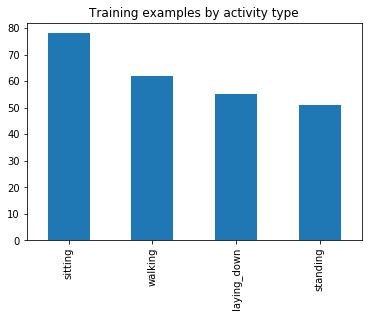

   mean_acc_x  mean_acc_y  mean_acc_z  std_acc_z  mad_acc_x  min_acc_x  \
0    1.369479   -6.591240    4.006797   2.649422   0.243341  -3.751834   
1    4.991783   -5.480297    3.667075   3.603165   1.497157  -3.358054   
2    3.941036   -6.451744    4.818964   3.131736   0.611717  -2.645655   
3    3.031641   -7.742162    4.125400   2.912465   0.248809  -0.505824   
4    2.750919   -8.956514    2.615709   1.939149   0.241896   1.478142   

   min_acc_y  max_acc_x  max_acc_y  max_acc_z   ...     mad_mfacc_jerk  \
0 -13.946607  10.937634   7.248540   9.954289   ...        7164.478061   
1 -19.297833  10.937634  11.613158  16.171380   ...        6984.974209   
2 -19.297833   9.229210  11.613158  16.171380   ...        8281.999556   
3 -12.020676   5.499350  -0.287129  10.414259   ...        8299.069413   
4 -16.148051   4.453503  -3.501215   7.122704   ...        8786.140902   

   max_mfacc_jerk  mean_macc  std_macc  mad_macc   max_macc     em_macc  \
0    68064.939122   9.987768  1.288

In [82]:
hist_activities(testing_set_df)
# plot_act_signals(in_df_ac)
testing_set_df = clean_dataset(testing_set_df)
combined_testing_df = testing_set_df
combined_testing_df = combined_testing_df.iloc[np.random.permutation(len(combined_testing_df))]
print testing_set_df.head()

In [83]:
testing_data = combined_testing_df[acc_cols+ accj_cols+ facc_jerk_cols+ facc_mag_cols+ facc_jmag_cols+ maccj_cols+ macc_cols].as_matrix()
testing_targets = testing_data[:, -1]
testing_data = testing_data[:, :-1]

std_scale = preprocessing.StandardScaler().fit(testing_data)
testing_data_std = std_scale.transform(testing_data)

print(len(testing_data_std), len(testing_data_std[0]))
print(len(testing_targets))

cache = {'laying_down' : 0, 'sitting' : 1, 'walking' : 2, 'standing' : 3}
testing_targets.reshape(len(testing_targets))
print(testing_targets.shape)

testing_bin_targets = []
for i in testing_targets:
    testing_bin_targets.append(cache[i])
print(len(testing_bin_targets))

testing_bin_targets[: 5]

(246, 39)
246
(246L,)
246


[0, 1, 3, 1, 0]

In [84]:
fileobj = open("combinedtestdf",'wb') 
pickle.dump(combined_testing_df, fileobj)
fileobj.close()
#f = open("combinedtestdf", 'r')
#combined_testing_df = pickle.load(f)
#f.close()

In [106]:
#model = DecisionTreeClassifier(random_state=0)
model = RandomForestClassifier(random_state = 42)
#model = SVC()
#model = KNeighborsClassifier()
#model = GaussianNB()
#model = LogisticRegression()
#model = MLPClassifier()

# Training the model
model.fit(training_data, training_bin_targets)

# Testing on the testing data
predicted_values = model.predict(testing_data)

In [107]:
cvscore = cross_val_score(model, testing_data, testing_bin_targets, cv=10)
print(cvscore)
print(np.mean(cvscore))

[ 0.96296296  1.          0.96        0.92        0.88        0.91666667
  0.91666667  0.95833333  0.86956522  0.91304348]
0.929723832528


In [108]:
acc_score = accuracy_score(testing_bin_targets, predicted_values)
print("Score: ", acc_score)

('Score: ', 0.43495934959349591)
